In [2]:
#!pip install pydynpd

In [3]:
#Import des modules
import random
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize_scalar
import pandas as pd
#import statsmodels.api as sm
import time
import matplotlib.pyplot as plt
from  pydynpd import regression
import  pydynpd as regg

from linearmodels import PanelOLS
from scipy import optimize


In [4]:
#Paramètre du modèle + génération des espilon
random.seed(2040)
n=100
T=10
phizero=0.4
a=np.array([np.random.normal(0,1) for i in range(n)])
y0=np.array([np.random.normal(a[i]/(1-phizero),1/np.sqrt(1-phizero**2)) for i in range(n)])
epsilon=[np.random.normal(0,1) for i in range(n*T)]

We generate the data in a matrix of dimension $N \times T$ with individuals in rows and the time in column.

$y_{i,t} = \phi_0 y_{i,t-1}+a_i+\epsilon_{i,t}$, with $a_i\sim N(0,1)$, $\epsilon_{i,t}\sim N(0,1)$ and $y_{i0}\sim N(\frac{a_i}{1-\phi_0},\frac{1}{\sqrt{1-\phi_0^2}})$

In [5]:
y=np.zeros((T,n))
y[0]=y0
y=y.T
for i in range(n):
    for j in range(1,T):
        y[i][j]=a[i]+phizero*y[i][j-1]+epsilon[i*T+j]

yit=y.reshape(n*T)

In [6]:
#Generation des first difference :
delta_y=np.zeros((n,T-1))
for i in range(n):
    for j in range(T-1):
        delta_y[i,j]=y[i,j+1]-y[i,j]

- GMM estimator (Andersen and Hsiao)

To compute the GMM, we de to use the pydynpd package (see https://github.com/dazhwu/pydynpd/blob/main/vignettes/Tutorial.ipynb).
We now define our model without the individual and time dummies (so a simple AR(1)), and the instruments we use after the "|" (we use all lags of order greater or equal to 2, consistently with equation (5) of the paper).

In [7]:
def data(y,n):
    df = pd.DataFrame(y)
    df = df.add_prefix('Y')
    df['id'] = range(n)
    df = pd.wide_to_long(df, "Y", i="id", j="time")
    df = df.reset_index(level=['id', 'time'])
    df = df.sort_values(by=['id', 'time'])
    return(df)

In [8]:
df = data(y,n)
command_str='Y L1.Y | gmm(Y, 2:.)'

In [9]:
#Print the result of the regression
mydpd = regression.abond(command_str, df, ['id', 'time'])

#Extract the result
user_command=regg.command.command(command_str,df.columns)
pdata = regg.panel_data.panel_data(df,  ['id', 'time'], user_command.variables, user_command.options)
model=regg.dynamic_panel_model.dynamic_panel_model(pdata, user_command.variables, user_command.options, command_str, user_command.part_2, user_command.part_3)
mydpd.regular_process(model)
mydpd.form_results(model)
model.regression_table["coefficient"][0]

 Dynamic panel-data estimation, two-step system GMM
 Group variable: id                               Number of obs = 900     
 Time variable: time                              Min obs per group: 9    
 Number of instruments = 45                       Max obs per group: 9    
 Number of groups = 100                           Avg obs per group: 9.00 
+------+------------+---------------------+------------+-----------+-----+
|  Y   |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+------+------------+---------------------+------------+-----------+-----+
| L1.Y | 0.4526354  |      0.0467176      | 9.6887633  | 0.0000000 | *** |
| _con | -0.0776375 |      0.1052101      | -0.7379281 | 0.4605581 |     |
+------+------------+---------------------+------------+-----------+-----+
Hansen test of overid. restrictions: chi(43) = 47.428 Prob > Chi2 = 0.297
Arellano-Bond test for AR(1) in first differences: z = -6.74 Pr > z =0.000
Arellano-Bond test for AR(2) in first differences

0.4526353683747971

In [10]:
#Function that gather the computation of GMM in a given data set
def GMM_estim(y,n,T):
    def data(y,n):
        df = pd.DataFrame(y)
        df = df.add_prefix('Y')
        df['id'] = range(n)
        df = pd.wide_to_long(df, "Y", i="id", j="time")
        df = df.reset_index(level=['id', 'time'])
        df = df.sort_values(by=['id', 'time'])
        return(df)

    df = data(y,n)
    command_str='Y L1.Y | gmm(Y, 2:.)'
    
    mydpd = regression.abond(command_str, df, ['id', 'time'])
    user_command=regg.command.command(command_str,df.columns)
    pdata = regg.panel_data.panel_data(df,  ['id', 'time'], user_command.variables, user_command.options)
    model=regg.dynamic_panel_model.dynamic_panel_model(pdata, user_command.variables, user_command.options, command_str, user_command.part_2, user_command.part_3)

    mydpd.regular_process(model)
    mydpd.form_results(model)
    estim=model.regression_table["coefficient"][0]
    
    return estim

GMM_estim(y,n,T)

 Dynamic panel-data estimation, two-step system GMM
 Group variable: id                               Number of obs = 900     
 Time variable: time                              Min obs per group: 9    
 Number of instruments = 45                       Max obs per group: 9    
 Number of groups = 100                           Avg obs per group: 9.00 
+------+------------+---------------------+------------+-----------+-----+
|  Y   |   coef.    | Corrected Std. Err. |     z      |   P>|z|   |     |
+------+------------+---------------------+------------+-----------+-----+
| L1.Y | 0.4526354  |      0.0467176      | 9.6887633  | 0.0000000 | *** |
| _con | -0.0776375 |      0.1052101      | -0.7379281 | 0.4605581 |     |
+------+------------+---------------------+------------+-----------+-----+
Hansen test of overid. restrictions: chi(43) = 47.428 Prob > Chi2 = 0.297
Arellano-Bond test for AR(1) in first differences: z = -6.74 Pr > z =0.000
Arellano-Bond test for AR(2) in first differences

0.4526353683747971

- Estimator of Han et Phillips 

We use here the generalized method of moments based on the moment : $$E(\Delta y_{it-1} \times [(2 \Delta y_{it} + \Delta y_{it-1})-\phi\Delta y_{it-1}])$$. 

The empirical counterpart of this condition gives the following estimators :
$$\hat(\phi)^{HP}=\frac{\sum_{i=1}^N\sum_{t=1}^T \Delta y_{it-1}(2\Delta y_{it-1}+\Delta y_{it-1})}{\sum_{i=1}^N\sum_{t=1}^T \Delta y_{it-1}^2}$$

In [11]:
def HP_estim_direct(y,n,T):
    #Implémentation directe
    numerateur=0
    denominateur=0
    for i in range(n) :
        for t in range(T):
            delta_1=y[i,t-1]-y[i,t-2]
            delta=y[i,t]-y[i,t-1]
            numerateur+=delta_1*(2*delta+delta_1)
            denominateur+=(delta_1)**2

    estim=numerateur/denominateur
   # print("Estimation directe: ",estim)
    return estim

HP_estim_direct(y,n,T)


0.3650641106433443

- Fixed effect maximum likelihood estimator

We compute the formula given in the paper : 
$$\hat{\phi}^{ML}=(y'_-Ay_-)^{-1}y'_-Ay$$
Where $y=(y_1,...,y_N)$ and $y_-=(y_{1-},...,y_{N-})$   with $y_i=(y_{i1},...,y_{iT})'$ and $y_i=(y_{i0},...,y_{iT-1})'$ , $A=I_N\otimes A_T$ with $A_T=I_T-\frac{1}{T}\iota'_T\iota_T$

In [15]:
#Formule du papier pour l'estimateur
def ML_papier(y,n,T):
    mat_y_=y[:,:T-1]
    mat_y=y[:,1:]
    
    y=mat_y.reshape(n*(T-1),1)
    y_=mat_y_.reshape(n*(T-1),1)
    
    i=np.array([np.ones(T-1)])
    A=np.kron(np.eye(n,n),(np.eye(T-1,T-1)-(1/(T-1))*i.T@i))
    
    phi_ML_aux=np.linalg.inv((y_.T)@A@y_)@((y_.T)@A@y)
    
    return phi_ML_aux

- Estimator of Hahn-Kuersteiner

This estimator is a debiased maximum likelyhood estimator. The formula is directly given in the paper.

In [16]:
def HK_estim_bis(y,n,T):
    theta = float(ML_papier(y,n,T))
    HK_estimate = ((T+1)/T)*theta + 1/T
    return(HK_estimate)


- Indirect inference estimator

1) We create a function that generate data for a given phi

2) We compute the binding function 

3) We minimise the distance between the binding function over the simulated data and over the real data

In [17]:
#Generate the data as at the beginning of the notebook
random.seed(2040)
def gener_donne(phi,n,T):
    phizero=float(phi)
    a=np.array([np.random.normal(0,1) for i in range(n)])
    y0=np.array([np.random.normal(a[i]/(1-phizero),1/np.sqrt(1-phizero**2)) for i in range(n)])
    epsilon=[np.random.normal(0,1) for i in range(n*T)]
    y=np.zeros((T,n))
    y[0]=y0
    y=y.T
    for i in range(n):
        for j in range(1,T):
            y[i][j]=a[i]+phizero*y[i][j-1]+epsilon[i*T+j]
    
    return y



This function allows to save time by using again the same set of $\epsilon_{it}$, $a_i$ and similar $y_0$ 


In [18]:
def gener_donne_partielle(phi,n,T,a,y0_,espsilon):
    phizero=float(phi)
    y=np.zeros((T,n))
    y0=(y0_+a/(1-phizero))*(1/np.sqrt(1-phizero**2))
    y[0]=y0
    y=y.T
    for i in range(n):
        for j in range(1,T):
            y[i][j]=a[i]+phizero*y[i][j-1]+epsilon[i*T+j]
    
    return y
    

In [19]:
#Compute of the simulated binding function
def b_NT(phi,H,n,T,a,y0_,epsilon):
    b_simul=[ML_papier(gener_donne_partielle(phi,n,T,a[H],y0_[H],epsilon[H]),n,T) for H in range(H)]
    return np.mean(b_simul)

In [20]:
#Minimization of the distance between simulated phi and real phi

def estim_indirect(H,y,n,T):
    x=ML_papier(y,n,T)
    
    a=[np.array([np.random.normal(0,1) for i in range(n)]) for h in range(H)]
    y0=[np.array([np.random.normal(0,1) for i in range(n)]) for h in range(H)]
    epsilon=[[np.random.normal(0,1) for i in range(n*T)] for h in range(H)]
    
    def ecartL2(phi):
        return abs(x-b_NT(phi,H,n,T,a,y0,epsilon))**2
    
    return minimize_scalar(ecartL2,method="bounded", bounds=(0.01,0.99)).x[0][0]


estim_indirect(100,y,n,T)

C:\Users\gaet9\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


0.3877313435404625

We can plot the binding function for different value of N and T.

[0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  0.99]


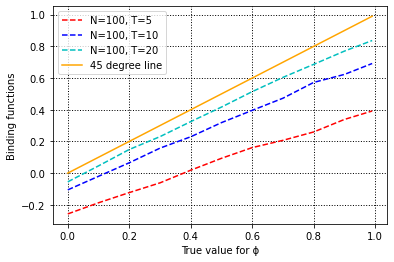

In [21]:
x=np.linspace(0,0.9,10)
x=np.append(x,0.99)
print(x)
liste_T=[5,10,20]
type_ligne=["r--","b--","c--"]


for t in range(len(liste_T)) :
    binding=[]
    T=liste_T[t]
    for i in x :
        estim=[]
        for a in range(20):
            y_rep=gener_donne(i,n,T)
            estim+=[ML_papier(y_rep,n,T)]
        binding+=[np.mean(estim)]
    
    plt.plot(x,binding,type_ligne[t],label="N="+str(n)+", T="+str(T)) 

    
plt.plot(x,x,"orange",label="45 degree line")
plt.grid(color='black', linestyle='dotted', linewidth=1)
plt.legend()
plt.xlabel('True value for \u03D5')
plt.ylabel('Binding functions')
plt.show()
    

- Comparison of different models

In [22]:
def RMSE(phi_estim_vec,phi):
    return np.sqrt(np.mean((np.array(phi_estim_vec)-np.array([phi]*len(phi_estim_vec)))**2))


RMSE([1,0.6,0],0.5)

0.41231056256176607

The function bellow computes the average bias and the root mean squared eror of a given estimator for a given number of replication

In [ ]:
def estim_ind(H):
    def estim_ind (y,n,T):
        return estim_indirect_bis(H,y,n,T)
    
    return estim_ind

#Fonction qui prend nb de replic, phi, n, T, l'estimateur

def replic_estim(n_replic,phi,n,T,fonction, verbose=False) :
    estim=[]
    for i in range(n_replic) :
        y=gener_donne(phi,n,T)
        estim+=[fonction(y,n,T)] 
        if(verbose):
            print(i)
    biais=np.mean(np.array(estim))-phi
    RMSE_mod=RMSE(estim,phi)
        
    return biais,RMSE_mod

print(replic_estim(n_replic=10,phi=0.5,n=100,T=10,fonction=HK_estim))
print(replic_estim(n_replic=10,phi=0.5,n=100,T=10,fonction=HP_estim_direct))
print(replic_estim(n_replic=10,phi=0.5,n=100,T=10,fonction=estim_ind(5), verbose=True))


We generate those parameters for the same value of N, T and $\phi_0$ as in the paper. 

In [ ]:
T_liste=[5]*8+[10]*8+[20]*8
N_liste=(([100]*4+[200]*4)*3)
phi_liste=[0,0.3,0.6,0.9]*6
resultat=pd.DataFrame(np.zeros((24,13)), columns=["T","N","phi","Biais GMM", "Biais ML","Biais HK", "Biais HP", "Biais indirect",
                                                  "RMSE GMM", "RMSE ML","RMSE HK", "RMSE HP", "RMSE indirect"])
resultat["T"]=T_liste
resultat["N"]=N_liste
resultat["phi"]=phi_liste

resultat
n_replic=30
for i in range(3):
    N=resultat["N"][i]
    T=resultat["T"][i]
    phi=resultat["phi"][i]
    print(N,T,phi)
    
    (resultat["Biais GMM"][i],resultat["RMSE GMM"][i])=replic_estim(n_replic=n_replic,phi=phi,n=N,T=T,fonction=GMM_estim)
    (resultat["Biais ML"][i],resultat["RMSE ML"][i])=replic_estim(n_replic=n_replic,phi=phi,n=N,T=T,fonction=ML_papier)
    (resultat["Biais HK"][i],resultat["RMSE HK"][i])=replic_estim(n_replic=n_replic,phi=phi,n=N,T=T,fonction=HK_estim_bis)
    (resultat["Biais HP"][i],resultat["RMSE HP"][i])=replic_estim(n_replic=n_replic,phi=phi,n=N,T=T,fonction=HP_estim_direct)
    (resultat["Biais indirect"][i],resultat["RMSE indirect"][i])=replic_estim(n_replic=n_replic,phi=phi,n=N,T=T,fonction=estim_ind(5))
    
   

We compute the average time taken to compute each estimator over five random data set.

In [ ]:
tempsGMM=[]
tempsML=[]
tempsHK=[]
tempsHP=[]
tempsII=[]

n=100
T=20
donnee_tps=pd.DataFrame(np.zeros((2,6)),columns=["phi","Times GMM","Times ML","Times HP","Times HK","Times II"])
phi_l=[0.5,0.75]
for j in range(2):
    tempsGMM=[]
    tempsML=[]
    tempsHK=[]
    tempsHP=[]
    tempsII=[]
    phi=phi_l[j]
    for i in range(5):
        y=gener_donne(phi,n,T)

        start_time = time.time()
        print(GMM_estim(y,n,T))
        tempsGMM += [(time.time() - start_time)]

        start_time = time.time()
        print(ML_papier(y,n,T))
        tempsML +=[(time.time() - start_time)]

        start_time = time.time()
        print(HP_estim_direct(y,n,T))
        tempsHP += [(time.time() - start_time)]
        
        print("CA CONTINUEEEE", i)
        start_time = time.time()
        print(HK_estim_bis(y,n,T))
        tempsHK += [(time.time() - start_time)]

        start_time = time.time()
        print(estim_ind(5)(y,n,T))
        tempsII += [(time.time() - start_time)]
        
    
    tempsGMM=np.array(tempsGMM)
    tempsML=np.array(tempsML)
    tempsHP=np.array(tempsHP)
    tempsHK=np.array(tempsHK)
    tempsGMM=np.array(tempsGMM)
    
    donnee_tps.iloc[j]=[phi,np.mean(tempsGMM),np.mean(tempsML),np.mean(tempsHP),np.mean(tempsHK),np.mean(tempsII)]
    



 
   

## Extensions

Now we evaluate the results of indirect inference for models that are more complicated than the AR(1). In the paper, the authors consider adding exogenous covariates or a time trend. We propose to extend their work in 2 other directions: by adding one lag (AR(2)) and by introducing non-linearity (probit AR(1)).

### AR(2)

In [ ]:
#function that computes biased coeff of first lag in AR(2)
def theta_AR2(y,n):
    df = data(y,n)
    df['Ylag'] = df.groupby('id')['Y'].shift()
    df['Ylag2'] = df.groupby('id')['Y'].shift(2)
    df = df.set_index(['id','time'])
    mod = PanelOLS.from_formula('Y ~ Ylag + Ylag2 + EntityEffects', df)
    est = mod.fit(cov_type='homoskedastic')
    theta = est.params[0]
    return(theta)

In [ ]:
#Exactement la même chose qu'au début
random.seed(2040)
def gener_donne_AR2(phi1,phi2,n,T):
    phi1=float(phi1)
    phi2=float(phi2)
    a=np.array([np.random.normal(0,1) for i in range(n)])
    y0=np.array([np.random.normal(a[i]/(1-phi1-phi2),np.sqrt((1-phi2)/((1+phi2)*(1-phi1-phi2)*(1+phi1-phi2)))) for i in range(n)])
    y1=np.array([np.random.normal(a[i]/(1-phi1-phi2),np.sqrt((1-phi2)/((1+phi2)*(1-phi1-phi2)*(1+phi1-phi2)))) for i in range(n)])
    epsilon=[np.random.normal(0,1) for i in range(n*T)]
    y=np.zeros((T,n))
    y[0]=y0
    y[1]=y1
    y=y.T
    for i in range(n):
        for j in range(2,T):
            y[i][j]=a[i]+phi1*y[i][j-1]+phi2*y[i][j-2]+epsilon[i*T+j]
    
    return y

In [ ]:
def gener_donne_partielle_AR2(phi1,phi2,n,T,a,y0_,y1_,espsilon):
    phi1=float(phi1)
    phi2=float(phi2)
    y=np.zeros((T,n))
    y0=(y0_+a/(1-phi1-phi2))*np.sqrt((1-phi2)/((1+phi2)*(1-phi1-phi2)*(1+phi1-phi2)))
    y1=(y1_+a/(1-phi1-phi2))*np.sqrt((1-phi2)/((1+phi2)*(1-phi1-phi2)*(1+phi1-phi2)))
    y[0]=y0
    y[1]=y1
    y=y.T
    for i in range(n):
        for j in range(2,T):
            y[i][j]=a[i]+phi1*y[i][j-1]+phi2*y[i][j-2]+epsilon[i*T+j]
    
    return y
    

In [ ]:
#we redefine the indirect inference function according to this new parameter

def b_NT_AR2(phi1,phi2,H,n,T,a,y0_,y1_,epsilon):
    b_simul=[theta_AR2(gener_donne_partielle_AR2(phi1,phi2,n,T,a[H],y0_[H],y1_[H],epsilon[H]),n) for H in range(H)]
    return np.mean(b_simul)

def estim_indirect_AR2(H,y,n,T):
    x=theta_AR2(y,n)
    
    a=[np.array([np.random.normal(0,1) for i in range(n)]) for h in range(H)]
    y0=[np.array([np.random.normal(0,1) for i in range(n)]) for h in range(H)]
    y1=[np.array([np.random.normal(0,1) for i in range(n)]) for h in range(H)]
    epsilon=[[np.random.normal(0,1) for i in range(n*T)] for h in range(H)]
    
    def ecartL2(phi):
        return abs(x-b_NT_AR2(phi[0],phi[1],H,n,T,a,y0,y1,epsilon))**2
    
    return optimize.fmin_bfgs(ecartL2, x0 = [0,0])[0] #,method="bounded", bounds=(0.01,0.99)).x[0][0]
    #return minimize_scalar(ecartL2,method="bounded", bounds=(0.01,0.99)).x[0][0]

We generate data from an AR(2) model, assuming that y0 and y1 follow the stationnary distribution of the AR(2) process.

In [ ]:
#Paramètre du modèle + génération des espilon
random.seed(2040)
n=100
T=10
phi1=0.7
phi2=0.2
a=np.array([np.random.normal(0,1) for i in range(n)])
y0=np.array([np.random.normal(a[i]/(1-phi1-phi2),np.sqrt((1-phi2)/((1+phi2)*(1-phi1-phi2)*(1+phi1-phi2)))) for i in range(n)])
y1=np.array([np.random.normal(a[i]/(1-phi1-phi2),np.sqrt((1-phi2)/((1+phi2)*(1-phi1-phi2)*(1+phi1-phi2)))) for i in range(n)])
epsilon=[np.random.normal(0,1) for i in range(n*T)]

On génère les données dans une matrice y de taille $N \times T$ avec en ligne les i et en colonne les T selon la formule :
$y_{i,t} = \phi_{1} y_{i,t-1} + \phi_{2} y_{i,t-2} + a_i + \epsilon_{i,t}$

In [ ]:
y=np.zeros((T,n))
y[0]=y0
y[1]=y1
y=y.T
for i in range(n):
    for j in range(2,T):
        y[i][j]=a[i]+phi1*y[i][j-1]+phi2*y[i][j-2]+epsilon[i*T+j]

In [ ]:
estim_indirect_AR2(10,y,n,T)

In [ ]:
def estim_ind(H):
    def estim_ind (y,n,T):
        return estim_indirect_AR2(H,y,n,T)

    return estim_ind

#Fonction qui prend nb de replic, phi, n, T, l'estimateur

def replic_estim_AR2(n_replic,phi1,phi2,n,T,fonction, verbose=False) :
    estim=[]
    for i in range(n_replic) :
        y=gener_donne_AR2(phi1,phi2,n,T)
        estim+=[fonction(y,n,T)] 
        if(verbose):
            print(i)
    biais=np.mean(np.array(estim))-phi1
    RMSE_mod=RMSE(estim,phi1)
        
    return biais,RMSE_mod

In [ ]:
T_liste=[10]*4
N_liste=[100]*4
phi1_liste=[0.5]*2 + [0.75]*2
phi2_liste=([-0.1,0.2])*2
resultat=pd.DataFrame(np.zeros((4,6)), columns=["T","N","phi1", "phi2", "Biais indirect", "RMSE indirect"])
resultat["T"]=T_liste
resultat["N"]=N_liste
resultat["phi1"]=phi1_liste
resultat["phi2"]=phi2_liste

resultat
n_replic=10
for i in range(4):
    N=resultat["N"][i]
    T=resultat["T"][i]
    phi1=resultat["phi1"][i]
    phi2=resultat["phi2"][i]
    print(N,T,phi1,phi2)
    
    (resultat["Biais indirect"][i],resultat["RMSE indirect"][i])=replic_estim_AR2(n_replic=n_replic,phi1=phi1,phi2=phi2,n=N,T=T,fonction=estim_ind(10))
    

## Appendix

Alternative method to compute HP estimator threw algorithmic minimization of the moment condition

In [ ]:
def HP_estim_algo(y,n,T):
    #implémentation par algo de maximisation
    def moment_HP(i,rho):
        moment_l=[]
        for t in range(3,T):
            delta_1=y[i,t-1]-y[i,t-2]
            delta=y[i,t]-y[i,t-1]
            moment_l+=[delta_1*(2*delta+delta_1)-rho*delta_1] 
        return moment_l

    def GMM_HP(rho):
        moments=[]
        for i in range(n):
            moments.append(np.array(moment_HP(i,rho)))
        M=1/(n-1)*sum([moments[i] for i in range(n-1)])
        return M@M.T

    estim2=minimize_scalar(GMM_HP, tol=0.01)
    print("Estimation par algo: ",estim2["x"])  
    
    return(estim2)

General formula for HK estimate

In [ ]:
def HK_estim(y,n,T):
    within_ = [1/T*sum([y[i][t-1] for t in range(1,T)]) for i in range(n)]
    within = [1/T*sum([y[i][t] for t in range(1,T)]) for i in range(n)]

    #Denominateur (le même pour OLS et HK, noté Upsilon):
    Upsilon=0
    for i in range(n):
        for t in range(1,T):
            Upsilon+=(y[i,t-1]-within_[i])**2

    Upsilon*=1/(n*T)

    #Numérateur (le même pour OLS et la première partie de HK)
    HK_num_1=0
    for i in range(n):
        for t in range(1,T):
            HK_num_1+=(y[i,t-1]-within_[i])*(y[i,t]-within_[i])
    HK_num_1*=1/(n*T)

    phi_OLS=HK_num_1/Upsilon

    omega=(1-phi_OLS**2)*Upsilon

    HK_num_2 = (1/T)*(1-phi_OLS)*omega

    HK_estim=(HK_num_1+HK_num_2)/Upsilon
    
    return HK_estim

print(HK_estim(y,n,T))

Direct implementation of GMM 

In [ ]:
z=[]
y
#On parcours tous les individus
for i in range(n):
    #On ajoute une ligne avec un zéros qui symbolise t=1
    z.append([[0]])
    
    #Pour tous les temps T>2, on ajoute les instruments jusqu'à yi0
    for t in range(2,T):
        instrument=[y[i,t-s] for s in range(2,t+1) ]
        z[i].append(instrument)

def h(rho,i,t):
    instr=z[i][t]
    return [inst*(delta_y[i,t]-rho*delta_y[i,t-1]) for inst in instr]

#On agrège tous les moments d'un individu donné dans un vecteur 
def tab_h(i,rho):
    tab_h=[]
    for t in range(1,T-1):
        tab_h+=h(rho,i,t)
    return np.array(tab_h)

#On définit le critère ci dessus.
def critere(rho):
    M=1/(n-1)*sum([tab_h(i,rho) for i in range(n-1)])
    return M@M.T

minimize_scalar(critere)